## 游戏简介

捕食者游戏说的是: 在一个固定的区域内，有三个对象，玩家，食物和敌人。玩家需要在不碰到敌人的情况下，找到食物。如果碰到了敌人就会被敌人吃掉。拿到食物即为胜利，被敌人吃掉的话就输了。

- 原文链接: https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/

## 导入依赖库

In [1]:
!pip install opencv-python

In [2]:
!pip install pillow

In [3]:
import numpy as np
import cv2
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

## 环境类

### 游戏主体对象实例化

在这个游戏中，会创建不同的实体，像食物food，玩家player和敌人enemy。他们都是在二维方格中的一个点，因此它们会有两个属性。x坐标和y坐标。

每个实体具备移动的属性，可以往x轴和y轴的任意方向移动。因此定义了如下函数:

```python
def move(self, x=False, y=False):
```

如果指定x和y移动多少，就按照指定的x和y进行移动。否者就随机进行移动。但是要注意是否移动出了边界，如果移动出了边界的话，就返回的是边界值。因此，在初始化的时候，我们需要指定地图的大小size。

进一步将move封装为action，抽象化为九个可选动作，函数原型如下:

```python
def action(self, choise):
```

最后我们还需要打印两个实体的位置信息，定义函数原型如下:

```python
def __str__(self):
    """打印这个实体的时候，如何显示"""
    return "x : {}, y : {}".format(self.x, self.y)
```

判断两个实体的相对位置:

```python
def __sub__(self, other):
    """位置间隔多少，通过一个减的操作实现"""
    return (self.x - other.x, self.y - other.y)
```

判断两个实体是否相等:

```python
def __eq__(self, other):
    """判断两个实例是否是相等的"""
    return self.x == other.x and self.y == other.y
```

In [4]:
class Cube(object):
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, size)  # 智能体的初始位置
        self.y = np.random.randint(0, size)  # 智能体的初始位置
        
    def action(self, choise):
        if choise == 0:
            self.move(x=1, y=1)
        elif choise == 1:
            self.move(x=-1, y=1)
        elif choise == 2:
            self.move(x=1, y=-1)
        elif choise == 3:
            self.move(x=-1, y=-1)
        elif choise == 4:
            self.move(x=0, y=1)
        elif choise == 5:
            self.move(x=0, y=-1)
        elif choise == 6:
            self.move(x=1, y=0)
        elif choise == 7:
            self.move(x=-1, y=0)
        elif choise == 8:  # 原地不动。
            self.move(x=0, y=0)
        else:
            print("ERROR ACTION!")
    
    def move(self, x=False, y=False):
        """x, y为给定的位置"""
        if not x:  # 如果没有给定x，就给一个随机的值，随机值属于【-1， 0， 1】
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        
        if not y:  # 如果没有给定y，就给一个随机的值，随机值属于【-1， 0， 1】
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
        
        if self.x < 0:  # 走出了边界，则赋值为0
            self.x = 0
        elif self.x >= self.size:
            self.x = self.size - 1
        
        if self.y < 0:  # 走出了边界，则赋值为0
            self.y = 0
        elif self.y >= self.size:
            self.y = self.size - 1
            
    def __str__(self):
        """打印这个实体的时候，如何显示"""
        return "x : {}, y : {}".format(self.x, self.y)

    def __sub__(self, other):
        """位置间隔多少，通过一个减的操作实现"""
        return (self.x - other.x, self.y - other.y)
    
    def __eq__(self, other):
        """判断两个实例是否是相等的"""
        return self.x == other.x and self.y == other.y

### 环境实例化

在能够实例化游戏主体对象时，我们就可以构造类似`gym`的游戏环境了。游戏环境中的核心方法有四个:

1. `def __init__(self):` 设置环境初始化的一些信息。
2. `def reset(self):`  重启环境的一些设定
3. `def step(self, action):` 实现环境的状态转移
4. `def render(self):` 对环境进行一个实时的渲染

通常在初始化的时候，我们需要调用`gym.spaces`中的方法来创建动作空间和状态空间。

`gym.spaces`的源码地址: https://github.com/openai/gym/tree/master/gym/spaces

- `Box`方法创建的方法有两种：

1. 对于每个维度都是相同的边界值

```bash
>>> Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
Box(3, 4)
```

2. 对于每个维度是不同的边界值

```bash
>>> Box(low=np.array([-1.0, -2.0]), high=np.array([2.0, 4.0]), dtype=np.float32)
Box(2,)
```
其中dtype定义的是空间中的数据类型。

- `Discrete`方法主要是创建一个离散的空间，从0到n-1。

例如:

```bash
>>> Discrete(2)
>>> Discrete(3, start=-1)  # {-1, 0, 1}
```

通过这种创建方式，我们就可以调用其内部的一些方法，比如像sample采样方法。

In [5]:
from gym import Env
from gym.spaces import Discrete, Box

class CubeEnv(Env):
    
    def __init__(self):
        self.MapSize = 10  # 地图大小
        self.ActionSpace = Discrete(9)
        # self.ActionSpace = Box(low=0, high=9, shape=(1,), dtype=np.int32) # 返回numpy数据类型。
        self.ObservationSpace = Box(low=-9, high=9, shape=(1, 4), dtype=np.int32)
        
        self.ReturnImage = False  # 是否返回图像。
    
        self.FoodReward = 25  # 食物的奖励是25分。
        self.EnemyReward = -300  # 遇到敌人的惩罚是-300分。
        self.MoveReward = -1  # 移动惩罚为-1分。

        self.d = {1:(255, 0, 0),  # blue
                 2:(0, 255, 0),  # green
                 3:(0, 0, 255)}  # red

        self.PlayerNum = 1  # 玩家为1号颜色
        self.FoodNum = 2 # 食物为2号颜色
        self.EnemyNum = 3 # 敌人为3号颜色

    
    def reset(self):
        self.player = Cube(self.MapSize)
        
        self.food = Cube(self.MapSize)
        while self.food == self.player:  # 当玩家位置与食物位置相同时，重新生成一遍。
            self.food = Cube(self.MapSize)
            
        self.enemy = Cube(self.MapSize)
        while self.enemy == self.food or self.enemy == self.player:  # 当敌人与食物或者玩家重叠时，重新生成一遍敌人。
            self.enemy = Cube(self.MapSize)
        
        if self.ReturnImage:
            obs = np.array(self.get_image())
        else:
            obs = (self.player - self.food) + (self.player - self.enemy)
        
        self.episode_step = 0 # 游戏step数清零。
        
        return obs
    
    def step(self, action):
        self.episode_step += 1
        
        self.player.action(action)
        self.food.move() # 食物随机移动一下
        self.enemy.move() # 敌人也随机移动一下
        
        if self.ReturnImage:
            # 如果需要返回图像的话，就将地图所有信息返回
            new_obs = np.array(self.get_image())
        else:
            # 返回坐标之间的相对位置
            new_obs = (self.player - self.food) + (self.player - self.enemy)
        
        if self.player == self.food:
            reward = self.FoodReward
        elif self.player == self.enemy:
            reward = self.EnemyReward
        else:
            reward = self.MoveReward
            
        done = False
        if self.player == self.food or self.player == self.enemy or self.episode_step >= 200:
            done = True
            
        return new_obs, reward, done
    
    def render(self):
        img = self.get_image()
        img = img.resize((800, 800))
        cv2.imshow('', np.array(img))
        cv2.waitKey(50)
        
    def get_image(self):
        env = np.zeros((self.MapSize, self.MapSize, 3), dtype=np.uint8)
        env[self.food.x][self.food.y] = self.d[self.FoodNum]
        env[self.player.x][self.player.y] = self.d[self.PlayerNum]
        env[self.enemy.x][self.enemy.y] = self.d[self.EnemyNum]
        img = Image.fromarray(env, "RGB")  # 展示游戏界面
        return img

In [6]:
env = CubeEnv()
env.ObservationSpace.shape

(1, 4)

In [7]:
env.ActionSpace.sample()

0

## Q-Learning

$$
Q^{\text {new }}\left(s_{t}, a_{t}\right) \leftarrow(1-\alpha) \cdot \underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{r_{t}}_{\text {reward }}+\underbrace{\gamma}_{\text {discount factor }} \cdot \underbrace{\max _{a} Q\left(s_{t+1}, a\right)}_{\text {estimate of optimal future value }})}^{\text {learned value }}
$$

In [8]:
class QLearning(object):
    def __init__(self, Env, LearningRate, Gamma, QTableName=None):
        """
        初始化函数
        # 参数env: 可用于获取状态和动作空间的大小。
        # 参数QTableName: QTableName表示Q表文件名的地址，默认为None。
        # 参数LearningRate: 表示Q-Learning的学习率。
        # 参数Gamma: 表示折扣因子。
        """
        self.env = Env
        self.QTableName = QTableName
        self.lr = LearningRate
        self.gamma = Gamma
        
        self.ActionSpaceValues = env.ActionSpace.n  # 获取动作空间维度的大小。
        self.ObsSpaceValues = env.ObservationSpace.shape  # 获取状态空间维度的大小。
        self.MapSize = env.MapSize # 获取地图维度的大小。
        
        self.InitQTable()  # 调用初始化q table函数初始化q table
    
    def InitQTable(self):
        """初始化Q Table"""
        
        if self.QTableName is None:  # Q Table不存在，将要进行随机初始化
            self.q_table = {}
            # q_table的每个状态范围是从-9到9的, 共19个变量。状态空间维度为4, 所以状态之间的组合有19的四次方种。
            for x1 in range(- self.MapSize + 1, self.MapSize):  # 玩家与食物之间的x轴距离。
                for y1 in range(- self.MapSize + 1, self.MapSize):  # 玩家与食物之间的y轴的距离。
                    for x2 in range(- self.MapSize + 1, self.MapSize):  # 玩家与敌人之间的x轴的距离。
                        for y2 in range(- self.MapSize + 1, self.MapSize):  # 玩家与敌人之间的y轴的距离。
                            self.q_table[(x1, y1, x2, y2)] = [np.random.uniform(-5, 0) 
                                                             for i in range(self.ActionSpaceValues)]
        else:  # 存在，将其从文件中加载进来
            with open(self.QTableName, 'rb') as f:
                self.q_table = pickle.load(f)
        
    
    def UpdateQTable(self, Obs, Action, Reward, NextObs):
        """
        更新 Q Table
        # 参数Obs表示当前的观测。
        # 参数Action表示当前观测下选择的实际动作。
        # 参数Reward表示当前观测下，执行实际选择的动作所获的的奖励。
        # 参数NextObs表示，执行完Action转移到的下一个状态。
        """
        
        old_q = self.q_table[obs][action]  # 从QTable中索引，获取到当前的Q值。
        
        # 如果已经迟到了食物，那么游戏会结束，下一个状态的Q值就是即时奖励。否则，就需要依据Q-Leaning的公式做更新计算。
        if Reward == self.env.FoodReward:
            new_q = Reward
        else:
            new_q = old_q + self.lr * (Reward + self.gamma * max(self.q_table[NextObs]) - old_q)
        
        self.q_table[obs][action] = new_q  # 将QTable中old Q进行更新。

## Q-Learning的训练主循环

### 训练参数设置

In [9]:
Episodes = 30000 # 智能体要玩这个游戏的局数为30000。
ShowEvery = 3000 # 每隔3000局展示一下当前局状况。
Epsilon = 0.6 # 百分之六十的随机动作，百分之四十的最大价值动作。
EpsDecay = 0.9998 # 随机动作减少的折扣数，每玩一局游戏，Epsilon减少EpsDecay多倍。

### 训练循环

In [10]:
env = CubeEnv()
agent = QLearning(Env=env, LearningRate=0.1, Gamma=0.95, QTableName=None)

episode_rewards = []

for episode in range(Episodes):
    obs = env.reset()
    done = False
    episode_reward = 0
    
    # 隔ShowEvery步打印并展示结果。
    if episode % ShowEvery == 0:
        print("episode {}, epsilon {}, mean reward {}".format(episode, 
                                                              Epsilon, np.mean(episode_rewards[ShowEvery:])))
        show = True
    else:
        show = False
    
    while not done:  # 如果当前这局游戏没有结束
        
        if np.random.random() > Epsilon:
            action = np.argmax(agent.q_table[obs])
        else:
            action = np.random.randint(0, env.ActionSpace.n)
        
        next_obs, reward, done = env.step(action)
        
        # 更新Agent中的Q table。
        agent.UpdateQTable(Obs=obs, Action=action, Reward=reward, NextObs=next_obs)
        
        # 更新当前观测
        obs = next_obs
        
        if show:
            env.render()
        
        episode_reward += reward
            
    episode_rewards.append(episode_reward)
    Epsilon *= EpsDecay

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 0, epsilon 0.6, mean reward nan
episode 3000, epsilon 0.32926722239570905, mean reward nan
episode 6000, epsilon 0.18069483957364205, mean reward -138.88766666666666
episode 9000, epsilon 0.09916147987941909, mean reward -123.47533333333334
episode 12000, epsilon 0.054417708414240505, mean reward -108.96133333333333
episode 15000, epsilon 0.029863279497827713, mean reward -97.28658333333334
episode 18000, epsilon 0.016388331819794114, mean reward -88.9928
episode 21000, epsilon 0.00899356749667138, mean reward -82.41227777777777
episode 24000, epsilon 0.00493547831509555, mean reward -76.95776190476191
episode 27000, epsilon 0.0027084853933429503, mean reward -72.14758333333333


## 绘图展示奖励曲线

为了直观查看智能体的学习过程，我们通常绘制其奖励曲线。这里采用`np.convolve()`方法对奖励曲线进行滤波处理。`np.convolve()`方法原理解释如下:


```bash
>>>np.convolve([3, 8, 10, 9, 11, 23, 44, 55, 57, 48], np.ones((3,))/3, mode='valid')
array([ 7.        ,  9.        , 10.        , 14.33333333, 26.        ,
    40.66666667, 52.        , 53.33333333])
```

可以看到它是将前3个的值取了平均。

27001


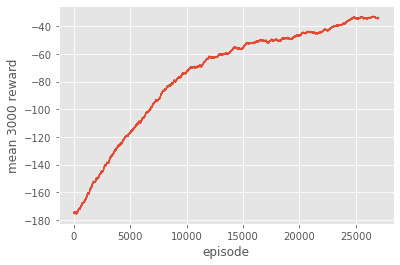

In [11]:
moving_avg = np.convolve(episode_rewards, np.ones(ShowEvery,)/ShowEvery, mode='valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode')
plt.ylabel('mean {} reward'.format(ShowEvery))
plt.show()

## 测试智能体

In [12]:
def test(agent, episodes, show_enable):
    env = CubeEnv()
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        
        episode_reward = 0
        
        while not done:
            action = np.argmax(agent.q_table[obs])
            obs, reward, done = env.step(action=action)
            if show_enable == True:
                env.render()
            
            episode_reward += reward
        
        print("episode {}, episode_reward {}".format(episode, episode_reward))

In [13]:
test(agent=agent, episodes=10, show_enable=True)

episode 0, episode_reward 16
episode 1, episode_reward -8
episode 2, episode_reward -20
episode 3, episode_reward 7
episode 4, episode_reward 16
episode 5, episode_reward -90
episode 6, episode_reward -14
episode 7, episode_reward 7
episode 8, episode_reward 25
episode 9, episode_reward -55
